# Импорты

In [1]:
import pandas as pd # 2.2.3 
import numpy as np # 2.0.1 
from collections import Counter

import matplotlib # 3.10.0
import matplotlib.pyplot as plt

import sklearn as scl # 1.6.1
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split 
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, f1_score
from skimage import measure


In [2]:
import os
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

os.environ['USER']='Oleg Zaytsev'

In [3]:
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,  confusion_matrix,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import accuracy_score

In [ ]:
# Написать в терминале conda activate ml_cls_env
# mlflow server --host 127.0.0.1 --port 5000

## Вызов функций для ML Flow

In [4]:
# Инициализация ML_flow
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment('Spoof_test1')

<Experiment: artifact_location='mlflow-artifacts:/251905958739995693', creation_time=1757138737139, experiment_id='251905958739995693', last_update_time=1757138737139, lifecycle_stage='active', name='Spoof_test1', tags={}>

# Загрузка данных

1. Добавлен код для вычисления **приращений невязок** - delta_dx, delta_dy (разница между соседними двумя точками)
2. Объединение невязок в один массив **combined_data**
3. Изменено создание датафрейма **df**, чтобы он включал все четыре признака: delat_x, delta_y, delta_dx, delta_dy  

In [5]:
# Импорт данных ГНСС (марковский процесс)
gnss_read = pd.read_csv('/wrk/data/processed/train_test/Для One-Class SVM/Синусоидальный спуфинг/mark_dist_data_sin_180.csv')
gnss_data = np.array(gnss_read[['gnss_x', 'gnss_y']])
labels = np.array(gnss_read['gnss_labels'])

# Импорт данных ИНС (винеровский процесс)
ins_read = pd.read_csv('//wrk/data/processed/train_test/Для One-Class SVM/Синусоидальный спуфинг/win_dist_data_lin_180.csv')
ins_data = np.array(ins_read[['ins_x', 'ins_y']])

# Вычисление невязок ГНСС и ИНС
delta_data = np.column_stack((gnss_data[:, 0] - ins_data[:, 0],
                              gnss_data[:, 1] - ins_data[:, 1]))

# >>> ИСПРАВЛЕНИЕ: Добавляем вычисление приращений невязок.
# Приращения - это разница между текущей и предыдущей невязкой.
# Мы используем np.diff для вычисления разницы.
delta_dx = np.diff(delta_data[:, 0], prepend=0) # prepend=0 добавляет 0 в начало, чтобы массив имел ту же длину
delta_dy = np.diff(delta_data[:, 1], prepend=0)

# >>> ИСПРАВЛЕНИЕ: Объединяем невязки и их приращения в один массив.
# Теперь у нас будет 4 признака: delta_x, delta_y, delta_dx, delta_dy.
combined_data = np.column_stack((delta_data, delta_dx, delta_dy))

# >>> ИСПРАВЛЕНИЕ: Создаем DataFrame с четырьмя признаками.
# Используем combined_data вместо delta_data.
# Это ключевое исправление, которое устранит последующую ошибку.
df = pd.DataFrame({'delta_x':combined_data[:, 0], 'delta_y':combined_data[:, 1],
                   'delta_dx':combined_data[:, 2], 'delta_dy':combined_data[:, 3],
                   'target':labels})

#Вывод распределения значений класса нормальных значений и аномалий
print(df['target'].value_counts(normalize = True))

print(df)

target
0    0.983056
1    0.016944
Name: proportion, dtype: float64
        delta_x    delta_y  delta_dx   delta_dy  target
0      0.609582   2.648731  0.609582   2.648731       0
1      8.372977   4.403480  7.763395   1.754750       0
2     14.839392   1.871612  6.466414  -2.531869       0
3     20.186453  -9.521980  5.347061 -11.393591       0
4     24.531844 -10.113208  4.345391  -0.591228       0
...         ...        ...       ...        ...     ...
3595  -5.443650 -25.753540  0.772140  -9.461340       0
3596  -2.159330 -23.690710  3.284320   2.062830       0
3597  -6.949030 -22.139580 -4.789700   1.551130       0
3598   1.482550 -24.472870  8.431580  -2.333290       0
3599   1.961990 -17.734060  0.479440   6.738810       0

[3600 rows x 5 columns]


# Разделение датасета

1. Исключение target из признаков

In [6]:
# Разделение датасета на тренировочные и тестовые данные
split_train = 2520 # число, определяющее, ДО какого значения используются данные для тренировочной выборки (!из числа программа затем вычтет 1)
split_test = 2520 # число, определяющее, С какого значения используются данные для тестовой выборки (!из числа программа затем вычтет 1)

# Обновим тренировочные и тестовые данные
# >>> ИСПРАВЛЕНИЕ: Теперь X_train_full и X_test_full содержат все 4 признака,
# исключая столбец 'target'.
X_train_full = df.iloc[0:split_train].drop('target', axis=1)
X_test_full = df.iloc[split_test:].drop('target', axis=1)

y_train = labels[0:split_train]
y_test = labels[split_test:]
 
# Проверка количества тренировочных и тестовых точек данных
print('Количество тренировочных данных: ', X_train_full.shape[0])
print('Количество тестовых данных: ', X_test_full.shape[0])
print('Количество нормальных значений в тренировочных данных: ', Counter(y_train)[0])
print('Количество аномальных значений в тестовых данных: ', Counter(y_test)[1])

print(y_train)
print(y_test)


Количество тренировочных данных:  2520
Количество тестовых данных:  1080
Количество нормальных значений в тренировочных данных:  2520
Количество аномальных значений в тестовых данных:  61
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


# Функция для определения устойчивых аномалий

In [7]:
def filter_sequential_anomalies(predictions, min_consecutive=3):
    """
    Обнуляет одиночные (или малые) аномалии, если они не идут подряд N раз.
    param predictions: список или массив предсказаний (0 = норм, 1 = аномалия)
    param min_consecutive: минимальное количество подряд идущих 1, чтобы считать это реальной аномалией
    return: обновлённый список предсказаний
    """
    predictions = np.array(predictions)
    filtered = predictions.copy()
    count = 0
    start_idx = None

    for i, val in enumerate(predictions):
        if val == 1:
            if count == 0:
                start_idx = i
            count += 1
        else:
            if 0 < count < min_consecutive:
                # Обнуляем слишком короткую последовательность
                filtered[start_idx:i] = 0
            count = 0
            start_idx = None

    # Обработка конца массива (если аномалии были в конце)
    if 0 < count < min_consecutive:
        filtered[start_idx:] = 0

    return filtered

# Обучение OneClass SVM 

In [8]:
# Обучение One-Class SVM
# лучшие значения были nu=0.001 gamma = 0.0001
one_class_svm = OneClassSVM(nu=0.001, kernel = 'rbf', gamma = 0.0001).fit(X_train_full)

In [9]:
# Прогнозирование на тестовом наборе данных
prediction = one_class_svm.predict(X_test_full)

# Изменение меток аномалий с -1 на 1 и меток нормальных данных с 1 на 0
prediction = [1 if i==-1 else 0 for i in prediction]
prediction = filter_sequential_anomalies(prediction, min_consecutive=1)  # в min_consecutive указать сколько раз подряд

# Оценка прогноза модели
print(classification_report(y_test, prediction))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1019
           1       0.89      0.84      0.86        61

    accuracy                           0.99      1080
   macro avg       0.94      0.92      0.93      1080
weighted avg       0.98      0.99      0.98      1080



## Обучение Isolation Forest

In [10]:
# Выделение валидационной выборки для подбора гиперпараметров
split_val = 3500
X_val = df.iloc[split_val:].drop('target', axis=1)
y_val = labels[split_val:]

In [11]:
# Стандартизация данных 
X_full = df.drop('target', axis=1)

scaler = StandardScaler()
scaler.fit(X_full) # Вычисление СКО и мат ожидания
X_train_full_s = scaler.transform(X_train_full) # Применение к данным

X_test_full_s = scaler.transform(X_test_full)

X_val_s = scaler.transform(X_val)


In [12]:
from itertools import product

In [13]:
param_grid = {
    'n_estimators':[1, 10,  50, 100, 200],
    'max_samples':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1.0]
}

best_score=-np.inf
best_params = None
results = []

for n_est, max_s in product(param_grid['n_estimators'],param_grid['max_samples']):
    my_classifier=IsolationForest(n_estimators=n_est,max_samples=max_s,random_state=42,warm_start=False)
    my_classifier.fit(X_train_full_s)
    
    anomaly_score_val = -my_classifier.decision_function(X_val_s)
    auc = roc_auc_score(y_val, anomaly_score_val)
    results.append(((n_est,max_s),auc))
    if auc >  best_score:
        best_score = auc 
        best_params = {'n_estimators':n_est, 'max_samples':max_s}
        
print("Лучшие  параметры:",best_params,'val_ROC_AUC:', best_score)

Лучшие  параметры: {'n_estimators': 1, 'max_samples': 0.3} val_ROC_AUC: 0.9972916666666666


In [ ]:
# --- Новый подбор параметров и оценка качества Isolation Forest ---
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.7, 1.0],
    'contamination': [0.01, 0.02, 0.05]
}

# Для IsolationForest y_train должен быть 1 (аномалия), -1 (норма)
y_train_isf = np.where(y_train == 1, 1, -1)

grid = GridSearchCV(IsolationForest(random_state=42), param_grid, scoring='f1', cv=3)
grid.fit(X_train_full_s, y_train_isf)
print('Лучшие параметры:', grid.best_params_)

# Обучаем лучшую модель на всех тренировочных данных
isf_best = IsolationForest(**grid.best_params_, random_state=42)
isf = isf_best.fit(X_train_full_s)

# Предсказания на тесте
prediction_isf = isf.predict(X_test_full_s)
prediction_isf = [1 if i == -1 else 0 for i in prediction_isf]
prediction_isf = filter_sequential_anomalies(prediction_isf, min_consecutive=1)

# F1-score для аномалий
f1 = f1_score(y_test, prediction_isf, pos_label=1)
print('F1-score для аномалий:', f1)

# Accuracy для сравнения
acc = accuracy_score(y_test, prediction_isf)
print('Accuracy:', acc)



Лучшие параметры: {'contamination': 0.01, 'max_samples': 0.7, 'n_estimators': 50}
F1-score для аномалий: 0.88
Accuracy: 0.9861111111111112


In [45]:
isf_best = IsolationForest(**grid.best_params_, random_state=42)
isf = isf_best.fit(X_train_full_s)

In [46]:
# Прогнозирование на тестовом наборе данных
prediction_isf = isf.predict(X_test_full_s)

# Изменение меток аномалий с -1 на 1 и меток нормальных данных с 1 на 0
prediction_isf = [1 if i==-1 else 0 for i in prediction_isf]
prediction_isf = filter_sequential_anomalies(prediction_isf, min_consecutive=1)  # в min_consecutive указать сколько раз подряд

# Оценка прогноза модели
print(classification_report(y_test, prediction_isf))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1019
           1       0.86      0.90      0.88        61

    accuracy                           0.99      1080
   macro avg       0.93      0.95      0.94      1080
weighted avg       0.99      0.99      0.99      1080



# Определение порогов

In [47]:
# Вычисление порогов
def find_max_radius_contour(model, feature_indices, grid_limit=500, grid_step=0.1):
    """
    Поиск максимального радиуса по контуру decision boundary (decision_function == 0)

    model: обученная OneClassSVM
    feature_indices: индексы признаков, по которым строится проекция (например [0,1] или [2,3])
    grid_limit: предел по оси (в метрах)
    grid_step: шаг сетки (в метрах)
    """
    x_range = np.arange(-grid_limit, grid_limit + grid_step, grid_step)
    y_range = np.arange(-grid_limit, grid_limit + grid_step, grid_step)
    xx, yy = np.meshgrid(x_range, y_range)

    # формируем матрицу точек
    n_points = xx.size
    # >>> ИСПРАВЛЕНИЕ: Изменяем размерность массива с 4 на количество признаков, на которых обучалась модель
    # (в данном случае, 4).
    n_features = model.n_features_in_
    test_points = np.zeros((n_points, n_features))
    test_points[:, feature_indices[0]] = xx.ravel()
    test_points[:, feature_indices[1]] = yy.ravel()

    # считаем decision function
    zz = model.decision_function(test_points).reshape(xx.shape)

    # находим контур по уровню 0
    contours = measure.find_contours(zz, level=0)

    if len(contours) == 0:
        print("Граница не найдена в заданных пределах.")
        return None, None

    # собираем все точки контура в одно облако
    contour_points = np.vstack(contours)

    # переводим координаты контурных точек из индексов в физические координаты
    x_contour = x_range[contour_points[:, 1].astype(int)]
    y_contour = y_range[contour_points[:, 0].astype(int)]

    # вычисляем расстояния от (0,0)
    radii = np.sqrt(x_contour**2 + y_contour**2)

    # максимальный радиус
    max_radius = np.max(radii)

    return max_radius, (x_contour, y_contour, radii)

max_radius_deltas_contour1, (x_contour_deltas1, y_contour_deltas1, radii_deltas) = find_max_radius_contour(
    one_class_svm, feature_indices=[0,1], grid_limit=500, grid_step=1)

print(f"Радиальный порог по невязке: {max_radius_deltas_contour1:.3f} м")

max_radius_deltas_contour, (x_contour_deltas, y_contour_deltas, radii_deltas) = find_max_radius_contour(
    one_class_svm, feature_indices=[2,3], grid_limit=500, grid_step=1)

print(f"Радиальный порог по приращению невязки: {max_radius_deltas_contour:.3f} м")


/opt/conda/envs/ml_cls_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


Радиальный порог по невязке: 192.938 м


/opt/conda/envs/ml_cls_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


Радиальный порог по приращению невязки: 168.861 м


## Подготовка

In [48]:
# Визуализация результатов моделирования и прогноза
# Обновляем создание df_test, чтобы использовать все 4 признака
df_test = X_test_full.copy()
df_test['one_class_svm_prediction'] = prediction
df_test['isolation_forest_prediction'] = prediction_isf

df_test['y_test'] = y_test

# Определяем все необходимые индексы и метки
normal_indices = df_test['one_class_svm_prediction'] == 0
spoof_indices = df_test['one_class_svm_prediction'] == 1
true_normal_indices = df_test['y_test'] == 0
true_spoof_indices = df_test['y_test'] == 1

# Вычисляем смещенные индексы для правильного отображения на временной шкале
# Это ключевой шаг, чтобы графики начинались с 2520, а не с 0.
x_axis_values = df_test.index
spoof_start_time_test_index = np.where(df_test['y_test'] == 1)[0][0]
spoof_end_time_test_index = np.where(df_test['y_test'] == 1)[0][-1] + 1

# Глобальные индексы для меток на графиках
spoof_start_global_index = spoof_start_time_test_index + split_test
spoof_end_global_index = spoof_end_time_test_index + split_test

print(f"Индексы `df_test` для графиков: от {x_axis_values.min()} до {x_axis_values.max()}")
print(f"Смещенные индексы для глобального представления: от {x_axis_values.min() + split_test} до {x_axis_values.max() + split_test}")

df_test.head()

Индексы `df_test` для графиков: от 2520 до 3599
Смещенные индексы для глобального представления: от 5040 до 6119


,delta_x,delta_y,delta_dx,delta_dy,one_class_svm_prediction,isolation_forest_prediction,y_test
2520,-17.67416,-0.60587,-102.06160,-28.68736,1,1,0
2521,-15.47305,-9.27860,2.20111,-8.67273,0,0,0
2522,-19.70420,-3.73226,-4.23115,5.54634,0,0,0
2523,-15.64621,-1.03589,4.05799,2.69637,0,0,0
2524,-22.50207,-8.37875,-6.85586,-7.34286,0,0,0


In [49]:
# Функция сохранения графиков в ML flow
def log_current_figure_to_mlflow(fig, name="plot1"):
    import tempfile, os
    with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as tmpfile:
        fig.savefig(tmpfile.name)
        mlflow.log_artifact(tmpfile.name, artifact_path="plots")
        tmpfile_path = tmpfile.name
    os.remove(tmpfile_path)

In [52]:
def experiment(models, X_train,  y_train, X_test, y_test, mlflow_experiment = None):

    if mlflow_experiment:
        mlflow.set_experiment(mlflow_experiment)
        
    results = {}
    for name, model in models.items():
        if mlflow_experiment:
            mlflow.start_run(run_name= name)
            if hasattr(model,'get_params'):
                try:
                    params = model.get_params()
                    safe_params = {k:str(v) for k, v in params.items()}
                    mlflow.log_params(safe_params)
                except Exception:
                    pass
        # --- Исправление для Isolation Forest ---
        if name == 'isolation_forest':
            # Используем новые параметры из GridSearchCV
            model = IsolationForest(**grid.best_params_, random_state=42)
            model.fit(X_train_full_s)
            prediction = model.predict(X_test_full_s)
            prediction = [1 if i == -1 else 0 for i in prediction]
            prediction = filter_sequential_anomalies(prediction, min_consecutive=1)
            acc = float(accuracy_score(y_test, prediction))
        elif name == 'one_class_svm':
            # Используем те же параметры и данные, что и в ручном режиме
            model = OneClassSVM(nu=0.001, kernel='rbf', gamma=0.0001)
            model.fit(X_train_full)
            prediction = model.predict(X_test_full)
            prediction = [1 if i == -1 else 0 for i in prediction]
            prediction = filter_sequential_anomalies(prediction, min_consecutive=1)
            acc = float(accuracy_score(y_test, prediction))
        else:
            model.fit(X_train, y_train)
            prediction = model.predict(X_test)
            prediction = [1 if i == -1 else 0 for i in prediction]
            prediction = filter_sequential_anomalies(prediction, min_consecutive=1)
            acc = float(accuracy_score(y_test, prediction))
            
        if mlflow_experiment:
            mlflow.log_metric('accuracy', acc)
            mlflow.sklearn.log_model(model, 'model')
            
            mlflow.log_artifact('/wrk/data/processed/train_test/Для One-Class SVM/Синусоидальный спуфинг/mark_dist_data_sin_180.csv',artifact_path='dataset_GNSS')
            mlflow.log_artifact('/wrk/data/processed/train_test/Для One-Class SVM/Синусоидальный спуфинг/win_dist_data_lin_180.csv',artifact_path='dataset_INS')
            
            start_idx = 3420
            end_idx = 3600

            # Обрезка данных
            gnss_filtered = gnss_read.iloc[start_idx:end_idx].copy()
            ins_filtered = ins_read.iloc[start_idx:end_idx].copy()
            
             # Сдвиг координат, чтобы отсчет начинался с нуля
            gnss_filtered['gnss_x_shifted'] = gnss_filtered['gnss_x'] - gnss_filtered['gnss_x'].iloc[0]
            gnss_filtered['gnss_y_shifted'] = gnss_filtered['gnss_y'] - gnss_filtered['gnss_y'].iloc[0]

            ins_filtered['ins_x_shifted'] = ins_filtered['ins_x'] - gnss_filtered['gnss_x'].iloc[0]
            ins_filtered['ins_y_shifted'] = ins_filtered['ins_y'] - gnss_filtered['gnss_y'].iloc[0]


            # ГРАФИК 1
            
            fig1=plt.figure(figsize=(6, 6))

            # График траекторий ГНСС и ИНС (вместе)
            plt.scatter(gnss_filtered['gnss_x_shifted'], gnss_filtered['gnss_y_shifted'], c='blue', s=4, label='ГНСС')
            plt.scatter(ins_filtered['ins_x_shifted'], ins_filtered['ins_y_shifted'], c='red', s=4, label='ИНС')

            plt.xlabel('x (м)')
            plt.ylabel('y (м)')
            plt.title('График траекторий ГНСС и ИНС')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            log_current_figure_to_mlflow(fig1, name="График траектории")
            plt.show()
            
            # ГРАФИК 2 (только для текущей модели)
            padding = 100
            x_min, x_max = df_test['delta_x'].min() - padding, df_test['delta_x'].max() + padding
            y_min, y_max = df_test['delta_y'].min() - padding, df_test['delta_y'].max() + padding
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
            grid_points = np.c_[xx.ravel(), yy.ravel()]
            zeros_proj = np.zeros((grid_points.shape[0], 2))
            input_grid = np.hstack((grid_points, zeros_proj))
            Z = one_class_svm.decision_function(input_grid).reshape(xx.shape)
            x2_min, x2_max = df_test['delta_dx'].min() - padding, df_test['delta_dx'].max() + padding
            y2_min, y2_max = df_test['delta_dy'].min() - padding, df_test['delta_dy'].max() + padding
            xx2, yy2 = np.meshgrid(np.linspace(x2_min, x2_max, 300), np.linspace(y2_min, y2_max, 300))
            grid_points2 = np.c_[xx2.ravel(), yy2.ravel()]
            zeros_proj2 = np.zeros((grid_points2.shape[0], 2))
            input_grid2 = np.hstack((zeros_proj2, grid_points2))
            Z2 = one_class_svm.decision_function(input_grid2).reshape(xx2.shape)
            cmap = {0: 'blue', 1: 'red'}
            if name == 'one_class_svm':
                pred_col = 'one_class_svm_prediction'
                model_title = 'OneClass SVM'
            elif name == 'isolation_forest':
                pred_col = 'isolation_forest_prediction'
                model_title = 'IsolationForest'
            else:
                pred_col = None
                model_title = name
            if pred_col is not None:
                fig, axes = plt.subplots(4, 1, figsize=(5, 15))
                # --- 1. Прогноз невязок ---
                colors = df_test[pred_col].map(cmap)
                axes[0].set_title(f'Прогноз невязок ({model_title})')
                axes[0].scatter(df_test['delta_x'], df_test['delta_y'], c=colors, s=10)
                axes[0].contour(xx, yy, Z, levels=[0], linewidths=2, colors='black', linestyles='--')
                axes[0].set_xlabel('Невязка по X')
                axes[0].set_ylabel('Невязка по Y')
                axes[0].grid(True)
                axes[0].legend(handles=[
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label=f'Норма ({model_title})', markerfacecolor='blue', markersize=8),
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label=f'Спуфинг ({model_title})', markerfacecolor='red', markersize=8),
                    matplotlib.lines.Line2D([0], [0], color='black', linestyle='--', label='Граница модели (SVM)')
                ])
                axes[0].set_xlim(x_min, x_max)
                axes[0].set_ylim(y_min, y_max)
                # --- 2. Истинные метки невязок ---
                true_colors = df_test['y_test'].map(cmap)
                axes[1].set_title('Истинные метки невязок')
                axes[1].scatter(df_test['delta_x'], df_test['delta_y'], c=true_colors, s=10)
                axes[1].contour(xx, yy, Z, levels=[0], linewidths=2, colors='black', linestyles='--')
                axes[1].set_xlabel('Невязка по X')
                axes[1].set_ylabel('Невязка по Y')
                axes[1].grid(True)
                axes[1].legend(handles=[
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Норма (Истина)', markerfacecolor='blue', markersize=8),
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Спуфинг (Истина)', markerfacecolor='red', markersize=8),
                    matplotlib.lines.Line2D([0], [0], color='black', linestyle='--', label='Граница модели (SVM)')
                ])
                axes[1].set_xlim(x_min, x_max)
                axes[1].set_ylim(y_min, y_max)
                # --- 3. Прогноз приращений ---
                colors2 = df_test[pred_col].map(cmap)
                axes[2].set_title(f'Прогноз приращений невязок ({model_title})')
                axes[2].scatter(df_test['delta_dx'], df_test['delta_dy'], c=colors2, s=10)
                axes[2].contour(xx2, yy2, Z2, levels=[0], linewidths=2, colors='black', linestyles='--')
                axes[2].set_xlabel('Приращение по X')
                axes[2].set_ylabel('Приращение по Y')
                axes[2].grid(True)
                axes[2].legend(handles=[
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label=f'Норма ({model_title})', markerfacecolor='blue', markersize=8),
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label=f'Спуфинг ({model_title})', markerfacecolor='red', markersize=8),
                    matplotlib.lines.Line2D([0], [0], color='black', linestyle='--', label='Граница модели (SVM)')
                ])
                axes[2].set_xlim(x2_min, x2_max)
                axes[2].set_ylim(y2_min, y2_max)
                # --- 4. Истинные метки приращений ---
                true_colors2 = df_test['y_test'].map(cmap)
                axes[3].set_title('Истинные метки приращений невязок')
                axes[3].scatter(df_test['delta_dx'], df_test['delta_dy'], c=true_colors2, s=10)
                axes[3].contour(xx2, yy2, Z2, levels=[0], linewidths=2, colors='black', linestyles='--')
                axes[3].set_xlabel('Приращение по X')
                axes[3].set_ylabel('Приращение по Y')
                axes[3].grid(True)
                axes[3].legend(handles=[
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Норма (Истина)', markerfacecolor='blue', markersize=8),
                    matplotlib.lines.Line2D([0], [0], marker='o', color='w', label='Спуфинг (Истина)', markerfacecolor='red', markersize=8),
                    matplotlib.lines.Line2D([0], [0], color='black', linestyle='--', label='Граница модели (SVM)')
                ])
                axes[3].set_xlim(x2_min, x2_max)
                axes[3].set_ylim(y2_min, y2_max)
                plt.tight_layout()
                log_current_figure_to_mlflow(fig, name=f"Прогноз невязок и приращений ({model_title})")
                plt.show()

                # ГРАФИК 3
                # Визуализация разницы x и y по времени
                fig2, axes2 = plt.subplots(2, 2, figsize=(15, 7), sharex=True)
                axes2[0, 0].set_title('Исходные данные (истинные метки)')
                axes2[0, 0].scatter(x_axis_values[true_normal_indices], df_test['delta_x'][true_normal_indices], c='blue', s=7, label='Нормальные значения')
                axes2[0, 0].scatter(x_axis_values[true_spoof_indices], df_test['delta_x'][true_spoof_indices], c='lime', s=7, label='Спуфинг')
                axes2[0, 0].set_ylabel('Невязка по x (м)')
                axes2[0, 0].axvline(spoof_start_global_index, color='black', linestyle='--', label='Начало спуфинга')
                axes2[0, 0].legend()
                axes2[0, 0].grid(True)
                axes2[1, 0].set_title('Исходные данные (истинные метки)')
                axes2[1, 0].scatter(x_axis_values[true_normal_indices], df_test['delta_y'][true_normal_indices], c='blue', s=7, label='Нормальные значения')
                axes2[1, 0].scatter(x_axis_values[true_spoof_indices], df_test['delta_y'][true_spoof_indices], c='lime', s=7, label='Спуфинг')
                axes2[1, 0].set_ylabel('Невязка по y (м)')
                axes2[1, 0].set_xlabel('Время(с)')
                axes2[1, 0].axvline(spoof_start_global_index, color='black', linestyle='--', label='Начало спуфинга')
                axes2[1, 0].legend()
                axes2[1, 0].grid(True)
                # --- прогноз по модели ---
                if name == 'one_class_svm':
                    pred_col = 'one_class_svm_prediction'
                    model_title = 'OneClass SVM'
                elif name == 'isolation_forest':
                    pred_col = 'isolation_forest_prediction'
                    model_title = 'IsolationForest'
                else:
                    pred_col = None
                    model_title = name
                if pred_col is not None:
                    normal_indices_model = df_test[pred_col] == 0
                    spoof_indices_model = df_test[pred_col] == 1
                    axes2[0, 1].set_title(f'Прогноз {model_title}')
                    axes2[0, 1].scatter(x_axis_values[normal_indices_model], df_test['delta_x'][normal_indices_model], c='blue', s=7, label='Нормальные значения')
                    axes2[0, 1].scatter(x_axis_values[spoof_indices_model], df_test['delta_x'][spoof_indices_model], c='lime', s=7, label='Спуфинг')
                    axes2[0, 1].set_ylabel('Невязка по x (м)')
                    axes2[0, 1].axvline(spoof_start_global_index, color='black', linestyle='--', label='Начало спуфинга')
                    axes2[0, 1].legend()
                    axes2[0, 1].grid(True)
                    axes2[1, 1].set_title(f'Прогноз {model_title}')
                    axes2[1, 1].scatter(x_axis_values[normal_indices_model], df_test['delta_y'][normal_indices_model], c='blue', s=7, label='Нормальные значения')
                    axes2[1, 1].scatter(x_axis_values[spoof_indices_model], df_test['delta_y'][spoof_indices_model], c='lime', s=7, label='Спуфинг')
                    axes2[1, 1].set_ylabel('Невязка по y (м)')
                    axes2[1, 1].set_xlabel('Время (с)')
                    axes2[1, 1].axvline(spoof_start_global_index, color='black', linestyle='--', label='Начало спуфинга')
                    axes2[1, 1].legend()
                    axes2[1, 1].grid(True)
                plt.tight_layout()
                log_current_figure_to_mlflow(fig2, name=f"Визуализация разницы x и y по времени ({model_title})")
                plt.show()
                # ГРАФИК 4
                if pred_col is not None:
                    if name == 'one_class_svm':
                        decision_scores = one_class_svm.decision_function(X_test_full)
                    elif name == 'isolation_forest':
                        decision_scores = isf.decision_function(X_test_full_s)
                    fig3=plt.figure(figsize=(15, 8))
                    plt.title(f'Значение функции прогноза {model_title} от времени', fontsize=20)
                    plt.plot(x_axis_values, decision_scores, label='Функция прогноза')
                    plt.axhline(0, color='red', linestyle='--', label='Порог (0)')
                    plt.axvline(spoof_start_global_index, color='blue', linestyle='--', label='Начало спуфинга')
                    plt.axvline(spoof_end_global_index, color='purple', linestyle=':', label='Конец спуфинга')
                    spoof_indices_model = df_test[pred_col] == 1
                    plt.scatter(x_axis_values[spoof_indices_model], decision_scores[spoof_indices_model], c='lime', s=20, label=f'Спуфинг по {model_title}')
                    plt.xlabel('Время (с)', fontsize=20)
                    plt.ylabel('Значение функции прогноза', fontsize=20)
                    plt.legend(fontsize=20)
                    plt.grid(True)
                    plt.tight_layout()
                    log_current_figure_to_mlflow(fig3, name=f"Визуализация функции прогноза ({model_title})")
                    plt.show()
                # ГРАФИК 5
                if pred_col is not None:
                    df_test['radial_increment'] = np.sqrt(df_test['delta_dx']**2 + df_test['delta_dy']**2)
                    fig4, axes4 = plt.subplots(1, 2, figsize=(15, 4), sharex=True)
                    axes4[0].set_title('Радиальное приращение (истинные метки)')
                    axes4[0].scatter(x_axis_values[true_normal_indices], df_test['radial_increment'][true_normal_indices], c='blue', s=7, label='Нормальные значения')
                    axes4[0].scatter(x_axis_values[true_spoof_indices], df_test['radial_increment'][true_spoof_indices], c='lime', s=7, label='Спуфинг')
                    axes4[0].set_ylabel('Радиальное приращение невязки (м)')
                    axes4[0].set_xlabel('Время (с)')
                    axes4[0].axvline(spoof_start_global_index, color='black', linestyle='--', label='Начало спуфинга')
                    axes4[0].axvline(spoof_end_global_index, color='purple', linestyle=':', label='Конец спуфинга')
                    axes4[0].legend()
                    axes4[0].grid(True)
                    normal_indices_model = df_test[pred_col] == 0
                    spoof_indices_model = df_test[pred_col] == 1
                    axes4[1].set_title(f'Радиальное приращение ({model_title})')
                    axes4[1].scatter(x_axis_values[normal_indices_model], df_test['radial_increment'][normal_indices_model], c='blue', s=7, label='Нормальные значения')
                    axes4[1].scatter(x_axis_values[spoof_indices_model], df_test['radial_increment'][spoof_indices_model], c='lime', s=7, label='Спуфинг')
                    axes4[1].set_ylabel('√(Δdx² + Δdy²) (м)')
                    axes4[1].set_xlabel('Время (с)')
                    axes4[1].axvline(spoof_start_global_index, color='black', linestyle='--', label='Начало спуфинга')
                    axes4[1].axvline(spoof_end_global_index, color='purple', linestyle=':', label='Конец спуфинга')
                    axes4[1].legend()
                    axes4[1].grid(True)
                    plt.tight_layout()
                    log_current_figure_to_mlflow(fig4, name=f"Вычисление радиального приращения ({model_title})")
                    plt.show()

            mlflow.end_run()
            
        results[name]  = {'accuracy':acc,'model':model}
        print(f"{name}:accuracy={acc:.4f}")
        
        
    return results
                

In [37]:
mlflow.end_run()

🏃 View run one_class_svm at: http://localhost:5000/#/experiments/846694693744956745/runs/9fe31994a22f49a0863c2ce6fd528039
🧪 View experiment at: http://localhost:5000/#/experiments/846694693744956745


2025/09/07 07:58:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/07 07:58:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


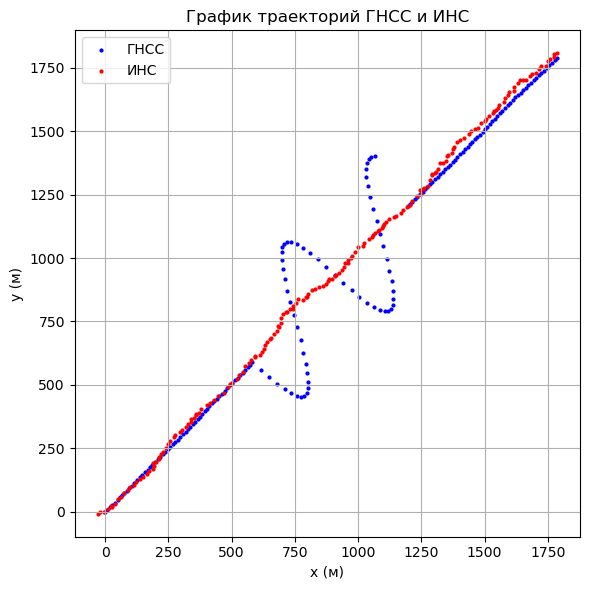

/opt/conda/envs/ml_cls_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/opt/conda/envs/ml_cls_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


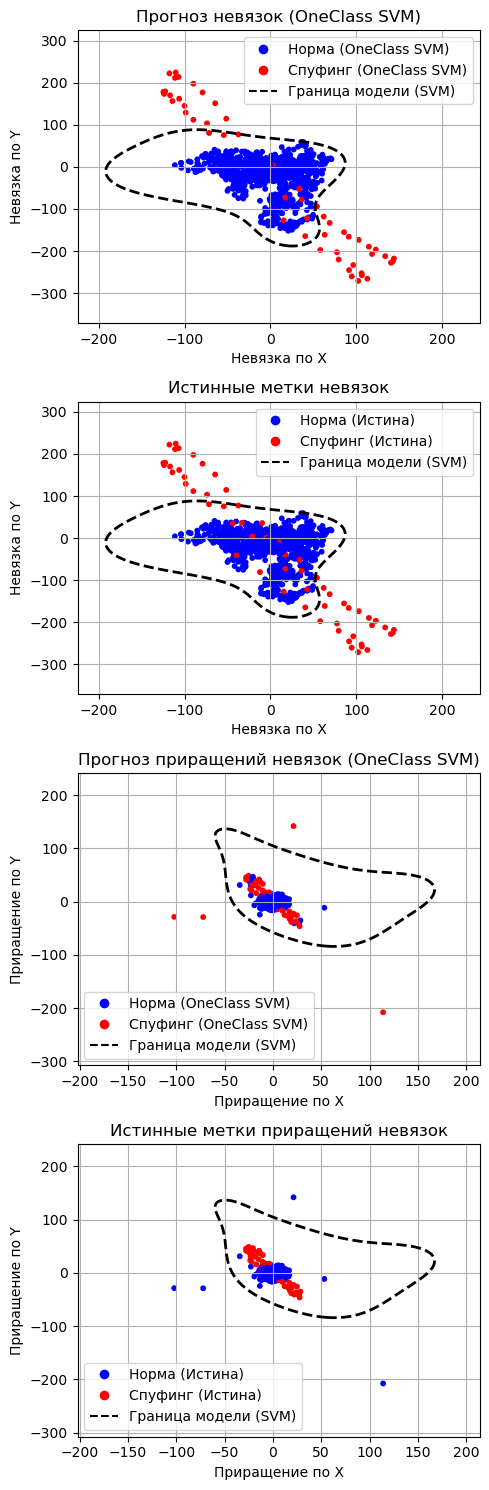

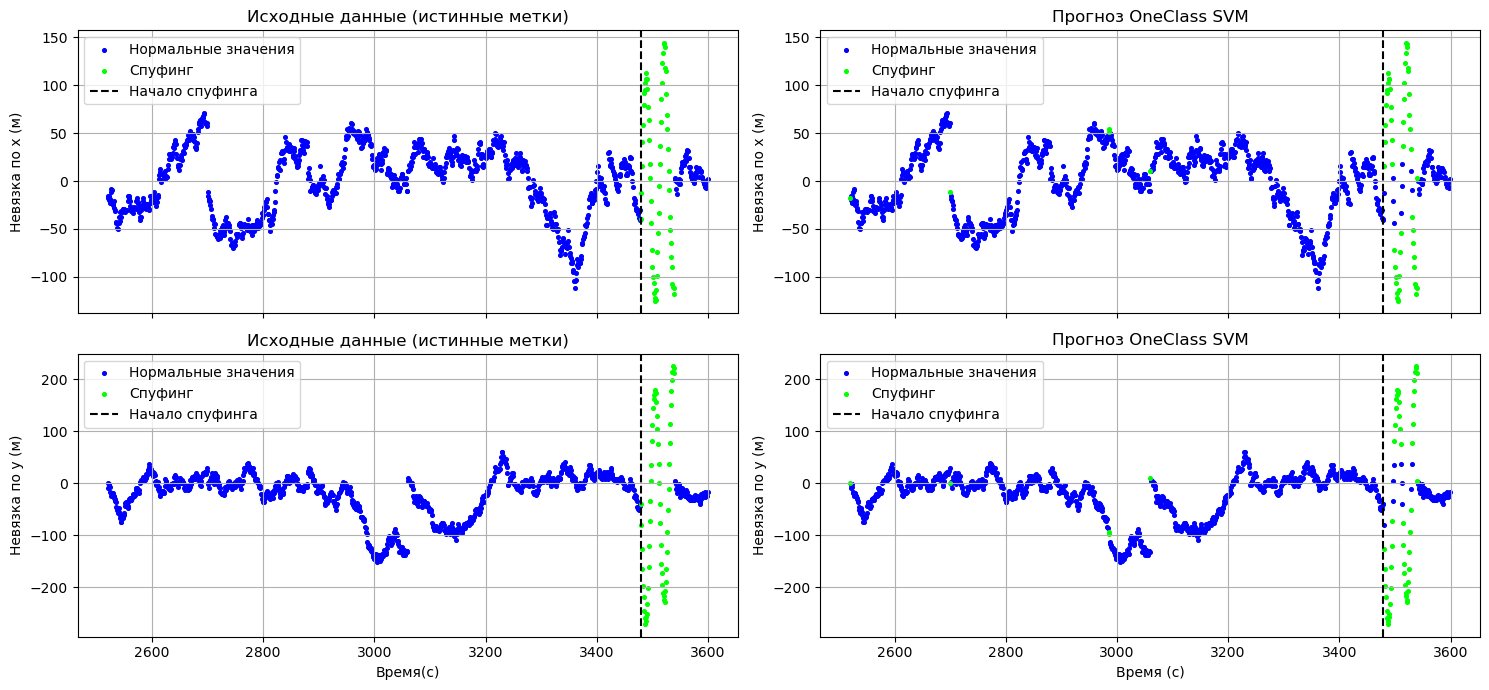

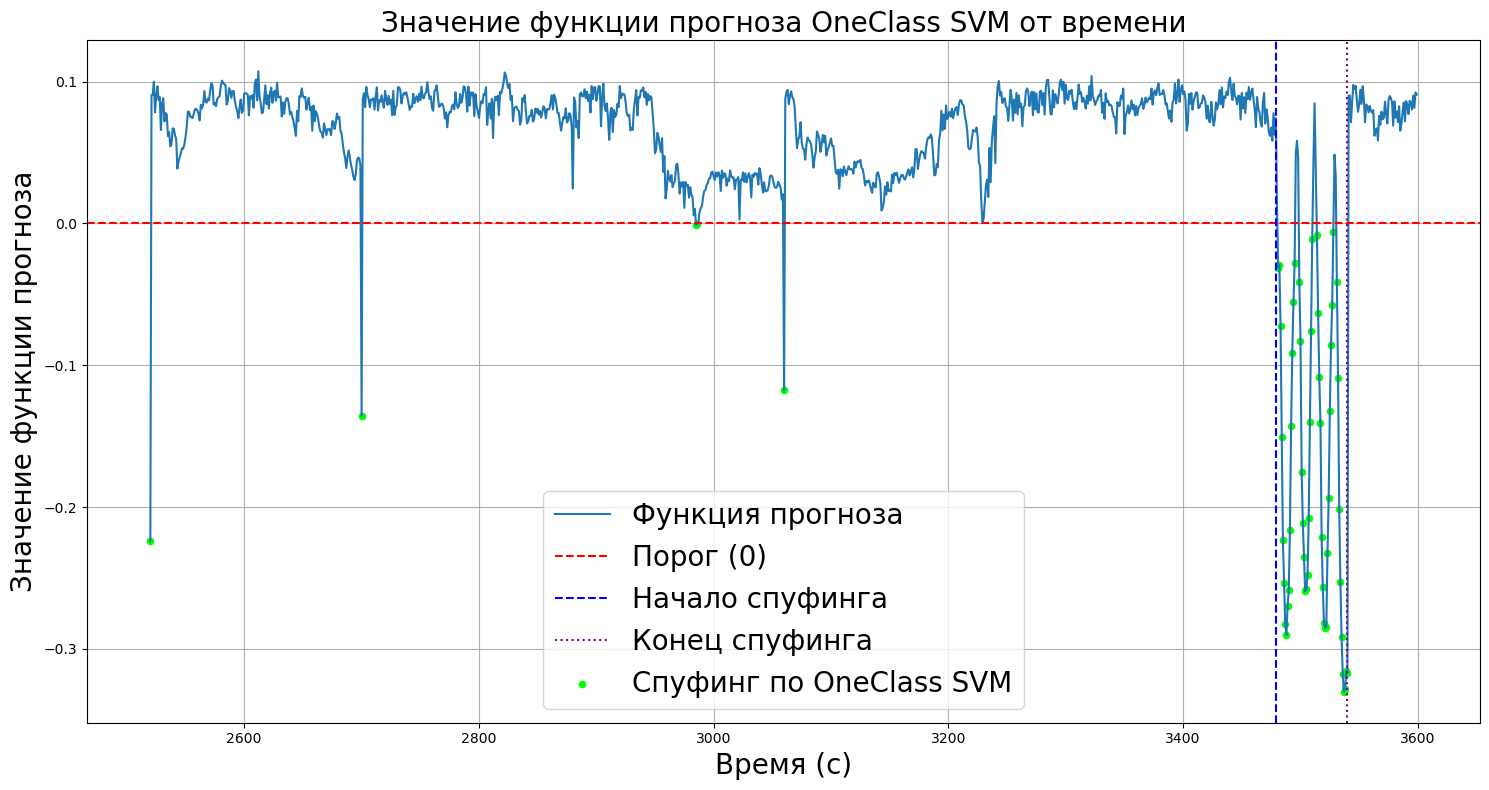

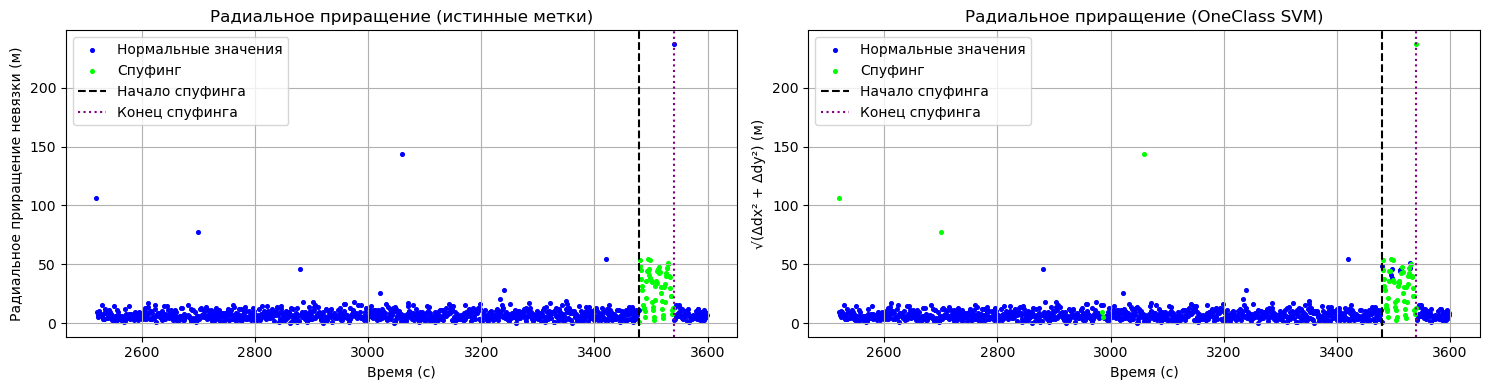

🏃 View run one_class_svm at: http://localhost:5000/#/experiments/846694693744956745/runs/cbd04ac14342471699511d54e8ee2b70
🧪 View experiment at: http://localhost:5000/#/experiments/846694693744956745
one_class_svm:accuracy=0.9852


2025/09/07 07:58:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/07 07:58:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


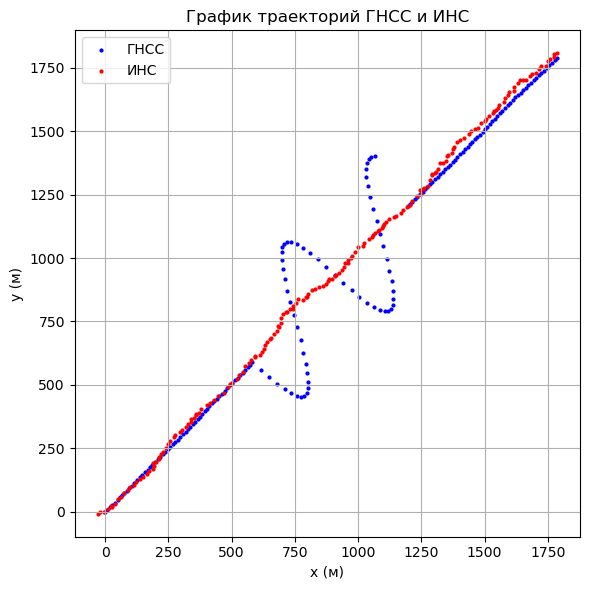

/opt/conda/envs/ml_cls_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(
/opt/conda/envs/ml_cls_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but OneClassSVM was fitted with feature names
  warnings.warn(


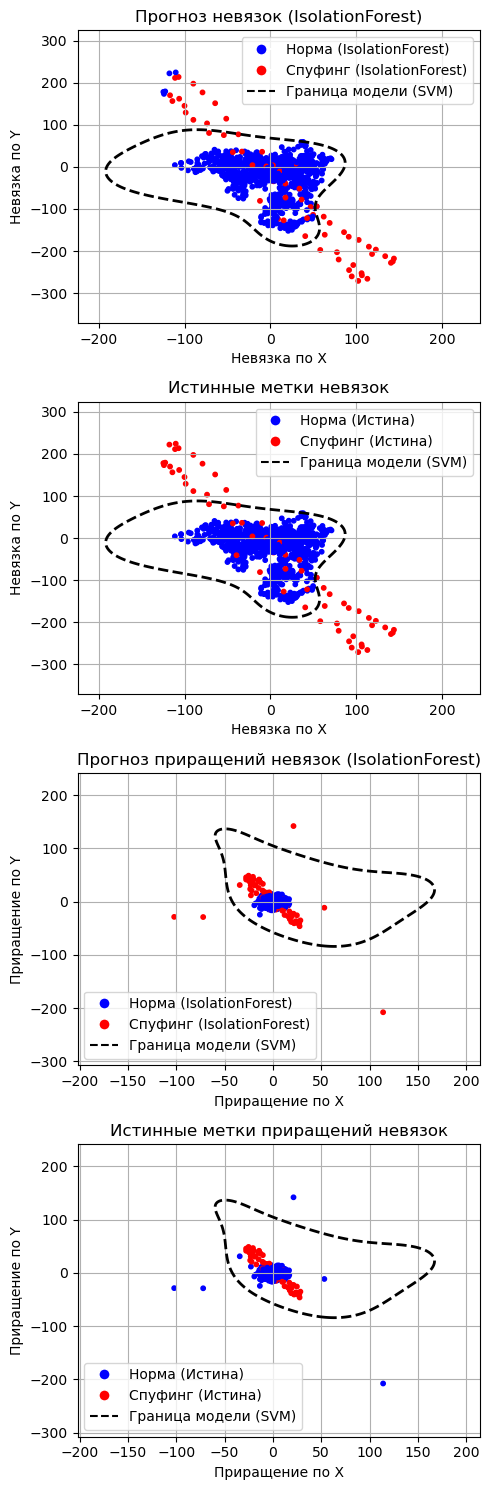

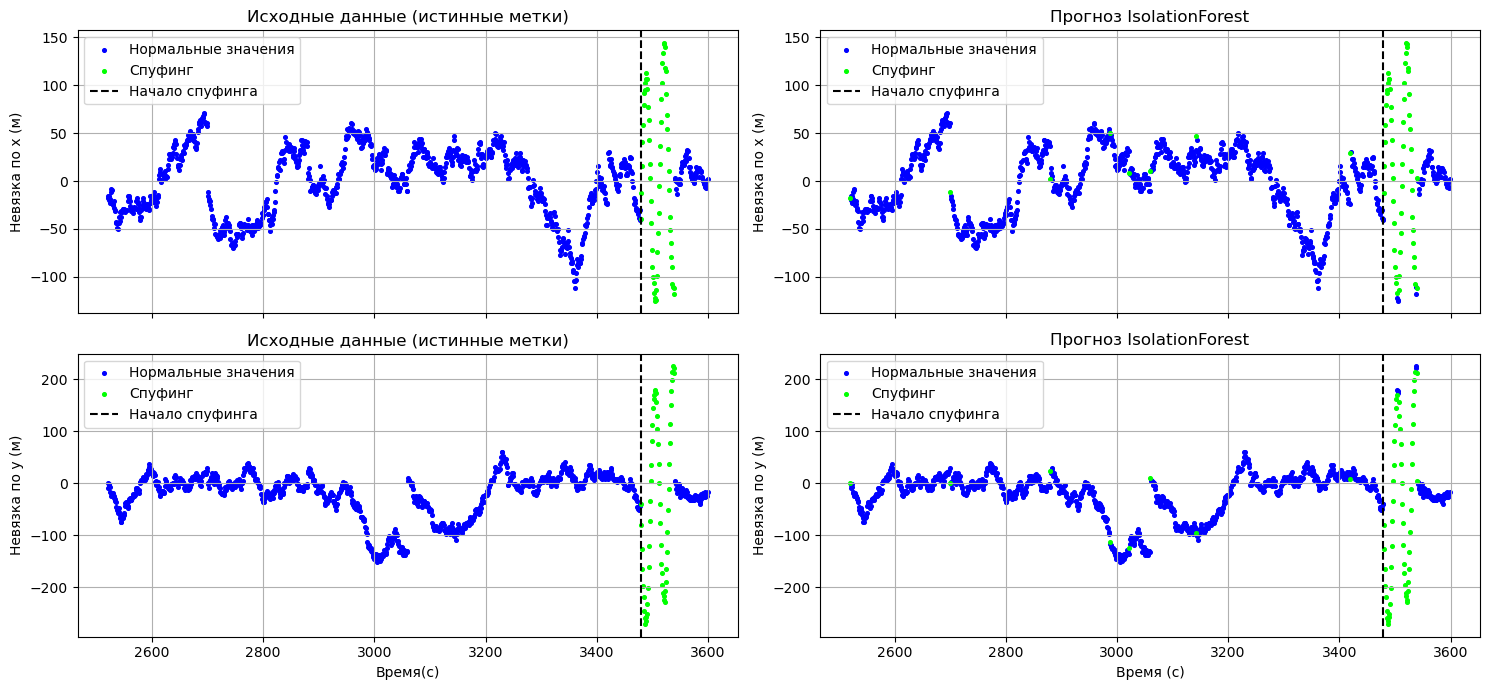

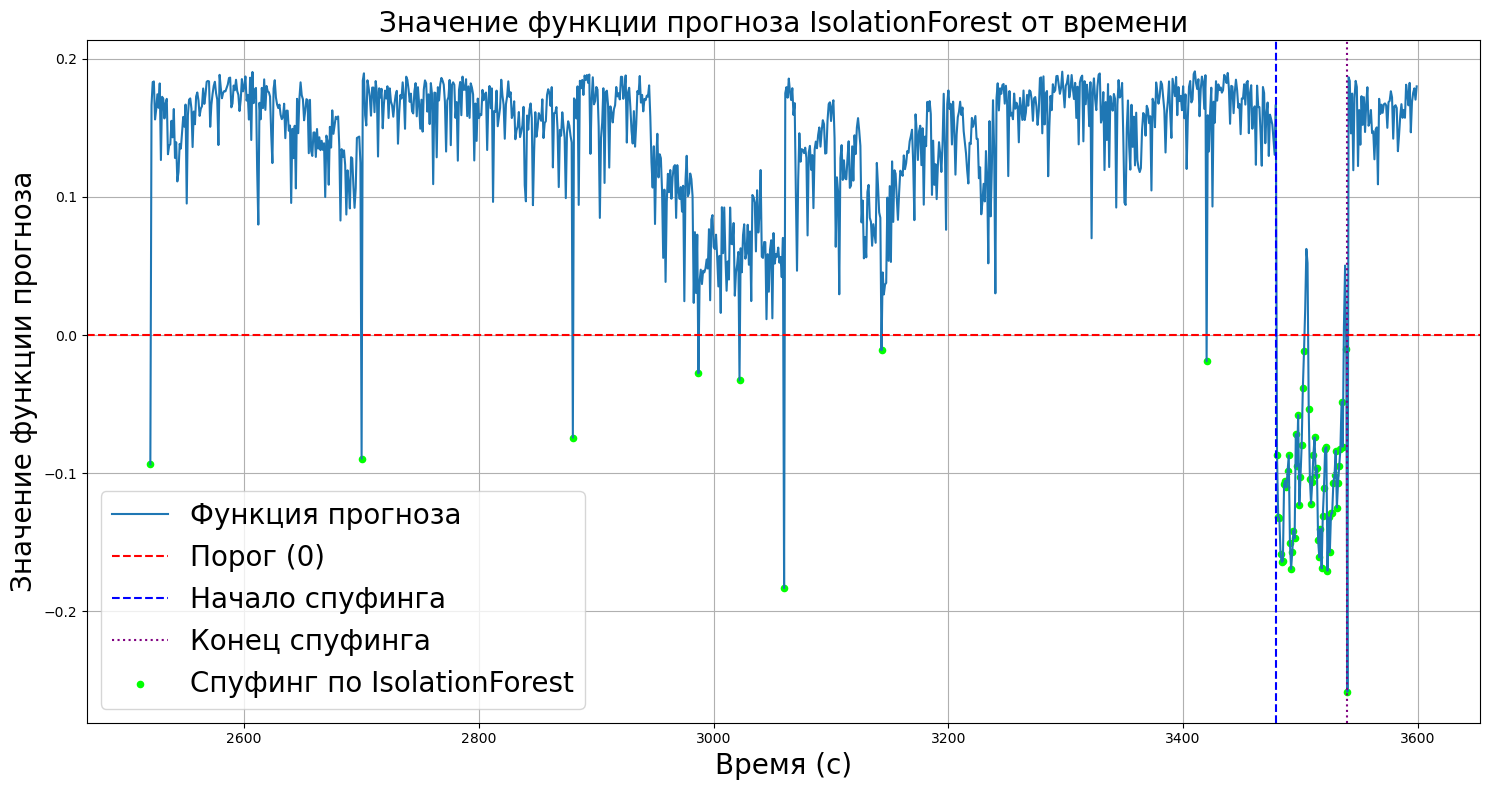

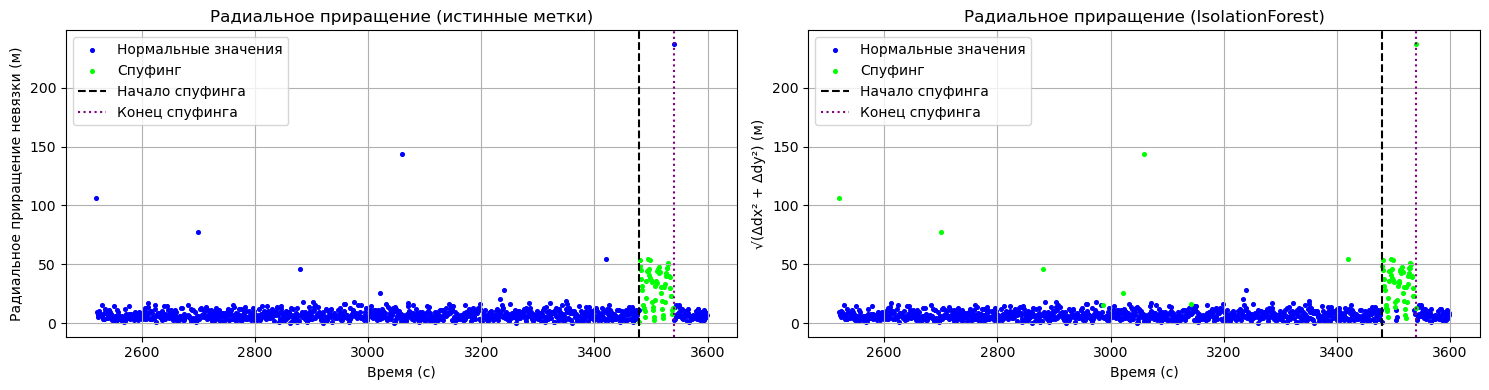

🏃 View run isolation_forest at: http://localhost:5000/#/experiments/846694693744956745/runs/ed66f1ee584f4fbcb99abd873719f6c3
🧪 View experiment at: http://localhost:5000/#/experiments/846694693744956745
isolation_forest:accuracy=0.9861


In [53]:
#  Словарь   моделей

models = {
    "one_class_svm": OneClassSVM(nu=0.001, kernel = 'rbf', gamma = 0.0001),
    "isolation_forest": IsolationForest(n_estimators = n_est, max_samples = max_s)
}

results = experiment(models, X_train_full_s, y_train, X_test_full_s, y_test, mlflow_experiment="my_experiment1")